In [87]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from scipy.interpolate import make_interp_spline, BSpline, UnivariateSpline

%matplotlib inline

In [8]:
def load_dataset():
    train_dataset = h5py.File('address of train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [9]:
# load the dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.
(50, 64, 64, 3)


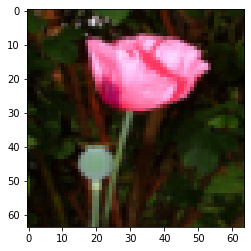

In [10]:
# one example
plt.imshow(train_set_x_orig[30])
print ("y = " + str(train_set_y[:, 30]) + ", it's a '" 
       + classes[np.squeeze(train_set_y[:, 30])].decode("utf-8") +  "' picture.")
print(test_set_x_orig.shape)

In [11]:
print([train_set_x_orig.shape,train_set_y.shape])
print([test_set_x_orig.shape,test_set_y.shape])

[(209, 64, 64, 3), (1, 209)]
[(50, 64, 64, 3), (1, 50)]


In [12]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [13]:
# flatten the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T


train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


## Start##

In [14]:
# use numpy
def sigmoid(z):
    z = 1 / (1 + np.exp(-z))
    return z

In [15]:
def initialize_zeros(dim):
    ###########################  
    weight = np.zeros((dim, 1))
    bias = 0
    ###########################  


    assert(weight.shape == (dim, 1))
    assert(isinstance(bias, float) or isinstance(bias, int))
    
    return weight, bias

In [16]:
def initialize_big(dim):
    ###########################  
    weight = np.random.random((dim, 1)) * 10
    bias = np.random.random(1)[0] * 10
    ###########################  


    assert(weight.shape == (dim, 1))
    assert(isinstance(bias, float) or isinstance(bias, int))
    
    return weight, bias

In [23]:
def initialize_small(dim):
    ###########################  
    weight = np.random.random((dim, 1)) * 0.0001
    bias = np.random.random(1)[0] * 0.0001
    ###########################  


    assert(weight.shape == (dim, 1))
    assert(isinstance(bias, float) or isinstance(bias, int))
    
    return weight, bias

In [18]:
def propagate(weight, bias, train_set, label):
    
    m = train_set.shape[1]
    X = train_set #(dim, batch_size)
    label = label.T #(batch_size, 1)
    
    ###########################  
    # compute activation
    activation = sigmoid(np.dot(X.T, weight) + bias) # (batch_size, 1)
    
    # compute cost
    cost = np.sum(- label * np.log(activation) - (1-label) * np.log(1-activation))              

    
    # backprop
    dw = 1/m * np.dot(X, (activation - label)) #(dim, 1)
    db = 1/m * np.sum(activation - label) #scalar 
    
    ###########################  
    assert(dw.shape == weight.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
#     print (cost.shape)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [19]:
def optimize(weight, bias, train_set, label, num_iterations, lr):
    costs = []
    
    for i in range(num_iterations):
        
    ###########################    
        # get the grads and cost with propagate()
        grads, cost = propagate(weight, bias, train_set, label)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update parameters
        weight = weight - lr * dw
        bias = bias - lr*db

        
    ###########################
    
        if i % 100 == 0:
            costs.append(cost)
            print ("Cost after iteration %i: %f" %(i, cost))
            
    
    params = {"weight": weight,
              "bias": bias}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [40]:
def predict(weight, bias, data):
    m = data.shape[1] #data:(dim, bsz)
    label = np.zeros((1,m))
    weight = weight.reshape(data.shape[0], 1) #(dim, 1)
    
    ###########################
    activation = sigmoid(np.dot(data.T, weight) + bias) #(bsz, 1)

    
    for i in range(activation.shape[0]):
        
        # Convert probabilities of activation to actual predictions [0 or 1]
        if activation[i][0] > 0.5:
            label[0][i] = 1
        else:
            label[0][i] = 0
    

    ###########################
    
    assert(label.shape == (1, m))
    
    return label

## Combine everything ##

In [29]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False, early_stop=False, init="zeros"):
    
    
    ###########################
    
    # initialize parameters 
    if init.lower() == "zeros":
        weight, bias = initialize_zeros(X_train.shape[0])
    elif init.lower() == "big":
        weight, bias = initialize_big(X_train.shape[0])
    else:
        weight, bias = initialize_small(X_train.shape[0])
    
    prev_dev = 0.0
    ## a modified version of early stopping
    highest_dev = 0.0
    for i in range(num_iterations//100):
        # Gradient descent 
        parameters, grads, costs = optimize(weight, bias, X_train, Y_train, 100, learning_rate)

        # Retrieve parameters weight and bias 
        weight = parameters["weight"]
        bias = parameters["bias"]

        # Predict test/train set examples 
        Y_prediction_test = predict(weight, bias, X_test)
        Y_prediction_train = predict(weight, bias, X_train)

        ###########################



        # Print train/test Errors
        train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
        if print_cost:
            print("train accuracy: {} %".format(train_acc))
        dev_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
        if print_cost:
            print("test accuracy: {} %".format(dev_acc))
        
        if early_stop and dev_acc < prev_dev:
              print ("Early Stop at iteration {}/{}".format((i+1)*100, num_iterations))
              break
        else:
            prev_dev = dev_acc
        highest_dev = max(highest_dev, dev_acc)


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : weight, 
         "b" : bias,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    print ("Highest Test Acc: ", highest_dev)
    print ("Final Test Acc: ", dev_acc)
    return d

In [25]:
## Compare different methods' results
## 1: Vanilla logistic regression, 1k iterations
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = 0.005, print_cost = False, init="zeros")



Cost after iteration 0: 144.867761
Cost after iteration 0: 122.162248
Cost after iteration 0: 97.592350
Cost after iteration 0: 78.585435
Cost after iteration 0: 69.275827
Cost after iteration 0: 63.384071
Cost after iteration 0: 58.494834
Cost after iteration 0: 54.348807
Cost after iteration 0: 50.774603
Cost after iteration 0: 47.652883
Highest Test Acc:  84.0
Final Test Acc:  72.0


The final test acc is much lower than the highest test acc, so it's likely to be overfitting.

In [26]:
# test your code
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = 0.005, print_cost = False, early_stop = True, init="zeros")


Cost after iteration 0: 144.867761
Cost after iteration 0: 122.162248
Early Stop at iteration 200/1000
Highest Test Acc:  84.0
Final Test Acc:  80.0


By using early stopping, the model stopped at iteration 200/1000 after the test acc starts to drop. This saves us some time. Also, the Final Test Acc is closer to the highest test acc.


Next, let's compare the effects of different initialization methods.

In [30]:
# zero initialize 
print ("zero initialization \n")
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = 0.005, print_cost = False, early_stop = True, init="zeros")

# big initialization
print ("\n\n big intialization \n")
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = 0.005, print_cost = False, early_stop = True, init="big")

# small initialization
print ("\n\n small initialization \n")
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = 0.005, print_cost = False, early_stop = True, init="small")



zero initialization 

Cost after iteration 0: 144.867761
Cost after iteration 0: 122.162248
Early Stop at iteration 200/1000
Highest Test Acc:  84.0
Final Test Acc:  80.0


 big intialization 

Cost after iteration 0: nan


/Users/sichenglei/Desktop/softwares/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/Users/sichenglei/Desktop/softwares/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 0: nan
Highest Test Acc:  66.0
Final Test Acc:  66.0


 small initialization 

Cost after iteration 0: 154.123091
Cost after iteration 0: 122.157190
Early Stop at iteration 200/1000
Highest Test Acc:  84.0
Final Test Acc:  80.0


We can see that too big initialization causes the loss to become nan. 

### Bonus: Hyper-parameter tuning

Hyper-parameters, such as the learning rate, can be tuned to optimise the performance. Here we try a set of different learning rates and observe the corresponding performance changes.

In [21]:
learning_rates = [0.1, 0.05, 0.005, 0.0005]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = i, print_cost = False, early_stop=True)
    print ('\n' + "-------------------------------------------------------" + '\n')

# for i in learning_rates:
#     plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

# plt.ylabel('cost')
# plt.xlabel('iterations (hundreds)')

# legend = plt.legend(loc='upper center', shadow=True)
# frame = legend.get_frame()
# frame.set_facecolor('0.90')
# plt.show()

learning rate is: 0.1
Cost after iteration 0: 144.867761


/Users/sichenglei/Desktop/softwares/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/Users/sichenglei/Desktop/softwares/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


Cost after iteration 0: 5003.632103
Cost after iteration 0: 4422.346986
Cost after iteration 0: 4854.407500
Cost after iteration 0: 4470.828552
Cost after iteration 0: nan
Early Stop at iteration 600/1000
Highest Test Acc:  74.0
Final Test Acc:  70.0

-------------------------------------------------------

learning rate is: 0.05
Cost after iteration 0: 144.867761
Cost after iteration 0: 214.281868
Early Stop at iteration 200/1000
Highest Test Acc:  56.0
Final Test Acc:  34.0

-------------------------------------------------------

learning rate is: 0.005
Cost after iteration 0: 144.867761
Cost after iteration 0: 122.162248
Early Stop at iteration 200/1000
Highest Test Acc:  84.0
Final Test Acc:  80.0

-------------------------------------------------------

learning rate is: 0.0005
Cost after iteration 0: 144.867761
Cost after iteration 0: 128.745442
Cost after iteration 0: 123.585220
Cost after iteration 0: 119.553544
Cost after iteration 0: 116.166059
Cost after iteration 0: 113.20

We can see that using learning rate 0.005 actually gives the best Test Accuracy. 

## F1 Score, ROC Curve

In [44]:
def predict_by_thres(activations, threshold):
    # activation: (bsz, 1)   
    m = activations.shape[0]
    label = np.zeros((1,m))
    for i in range(activation.shape[0]):
        
        # Convert probabilities of activation to actual predictions [0 or 1]
        if activation[i][0] >= threshold:
            label[0][i] = 1
        else:
            label[0][i] = 0
    

    ###########################
    
    assert(label.shape == (1, m))
    
    return label

In [38]:
def compute_F1(labels, activations, threshold):
    preds = predict_by_thres(activations, threshold)
    assert labels.shape == preds.shape
    ## input shape: (1, bsz)
    
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    
    for i in range(labels.shape[1]):
        if labels[0][i] == 1 and preds[0][i] == 1:
            true_pos += 1
        elif labels[0][i] == 1 and preds[0][i] == 0:
            false_neg += 1
        elif labels[0][i] == 0 and preds[0][i] == 1:
            false_pos += 1
        elif labels[0][i] == 0 and preds[0][i] == 0:
            true_neg += 1
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    print ("precision: {}, recall: {}, F1: {}".format(precision, recall, F1))
    return [true_pos, true_neg, false_pos, false_neg, precision, recall, F1]
    
    

In [42]:
# get model and activations first 
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 100, learning_rate = 0.005, print_cost = False, early_stop = True, init="zeros")
weight = d["w"]
bias = d["b"]
activation = sigmoid(np.dot(test_set_x.T, weight) + bias) #(bsz, 1)


Cost after iteration 0: 144.867761
Highest Test Acc:  84.0
Final Test Acc:  84.0


In [74]:
tp_list = []
fp_list = []
# try different threshold
for i in range(1, 10):
    thres = i * 0.1
    print ("Current Threshold: ", thres)
    lst = compute_F1(test_set_y, activation, thres)
    tp_list.append(lst[-2])
    fp_list.append(lst[2]/(lst[2]+lst[1]))

Current Threshold:  0.1
precision: 0.66, recall: 1.0, F1: 0.7951807228915663
Current Threshold:  0.2
precision: 0.66, recall: 1.0, F1: 0.7951807228915663
Current Threshold:  0.30000000000000004
precision: 0.6875, recall: 1.0, F1: 0.8148148148148148
Current Threshold:  0.4
precision: 0.7857142857142857, recall: 1.0, F1: 0.88
Current Threshold:  0.5
precision: 0.8378378378378378, recall: 0.9393939393939394, F1: 0.8857142857142858
Current Threshold:  0.6000000000000001
precision: 0.8, recall: 0.7272727272727273, F1: 0.761904761904762
Current Threshold:  0.7000000000000001
precision: 0.8260869565217391, recall: 0.5757575757575758, F1: 0.6785714285714286
Current Threshold:  0.8
precision: 0.8, recall: 0.24242424242424243, F1: 0.372093023255814
Current Threshold:  0.9
precision: 1.0, recall: 0.030303030303030304, F1: 0.05882352941176471


Text(0, 0.5, 'true positive rate')

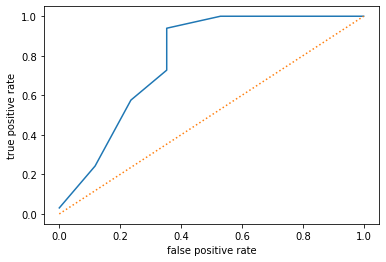

In [75]:
## Plot ROC Curve

plt.plot(fp_list, tp_list)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), ':')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")